### Binary classification based on 3 layers neural network
#### author: Kim Jeong Min

##### load images

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl


transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = 'horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)  


validation_data_path = 'horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1)  

IMAGE_VECTOR_SIZE = 10000

train_data = np.empty((IMAGE_VECTOR_SIZE,0))
train_label = np.empty((0,1))
validation_data = np.empty((IMAGE_VECTOR_SIZE,0))
validation_label = np.empty((0,1))

# load training images of the batch size for every iteration
for i, data in enumerate(trainloader):
    # inputs is the image
    # labels is the class of the image
    inputs, labels = data
    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    train_data = np.hstack((train_data, np.reshape(inputs, (10000,1))))
    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    # human: 1, horse: 0
    train_label = np.append(train_label, 1 if sum(labels)>0 else 0)  

# load validation images of the batch size for every iteration
for i, data in enumerate(valloader):
    # inputs is the image
    # labels is the class of the image
    inputs, labels = data
    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    validation_data = np.hstack((validation_data, np.reshape(inputs, (10000,1))))
    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    # human: 1, horse: 0
    validation_label = np.append(validation_label, 1 if sum(labels)>0 else 0)

##### neural network architecture

In [2]:
INPUT_DIM = IMAGE_VECTOR_SIZE
SECOND_DIM = 300
THIRD_DIM = 100
OUTPUT_DIM = 1

nn_architecture = [
    {"input_dim": INPUT_DIM, "output_dim": SECOND_DIM, "activation": "sigmoid"},
    {"input_dim": SECOND_DIM, "output_dim": THIRD_DIM, "activation": "sigmoid"},
    {"input_dim": THIRD_DIM, "output_dim": OUTPUT_DIM, "activation": "sigmoid"},
]

In [3]:
def init_layers(nn_architecture, seed = 99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [4]:
ALPHA = 0.01

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def tanh(Z):
    return np.tanh(Z)

def lrelu(Z):
    return np.maximum(ALPHA * Z, Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

def tanh_backward(dA, Z):
    th = tanh(Z)
    return dA * (1-th) * (1+th)

def lrelu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= (ALPHA * Z)] = ALPHA * Z
    return dZ

In [5]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    elif activation is "tanh":
        activation_func = tanh
    elif activation is "lrelu":
        activation_func = lrelu
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

In [6]:
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

In [7]:
def safe_log(arr):
    res = np.log(arr)
    res[np.isneginf(res)]=-10
    return res

def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1 / m * (np.dot(Y, safe_log(Y_hat).T) + np.dot(1 - Y, safe_log(1 - Y_hat).T))
    return np.squeeze(cost)

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = np.round(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [8]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    elif activation is "tanh":
        backward_activation_func = tanh_backward
    elif activation is "lrelu":
        backward_activation_func = lrelu_backward
    else:
        raise Exception('Non-supported activation function')
        
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [9]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    m = len(Y)
    Y = Y.reshape(Y_hat.shape)
   
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [10]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture):
        params_values["W" + str(layer_idx+1)] -= learning_rate * grads_values["dW" + str(layer_idx+1)]        
        params_values["b" + str(layer_idx+1)] -= learning_rate * grads_values["db" + str(layer_idx+1)]

    return params_values;

In [11]:
def train(X, Y, vX, vY, nn_architecture, epochs, learning_rate):
    params_values = init_layers(nn_architecture, 2)
    cost_history = []
    vcost_history = []
    accuracy_history = []
    vaccuracy_history = []
    
    for i in range(epochs):
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        vY_hat, vcashe = full_forward_propagation(vX, params_values, nn_architecture)
        cost = get_cost_value(Y_hat, Y)
        vcost = get_cost_value(vY_hat, vY)
        cost_history.append(cost)
        vcost_history.append(vcost)
        accuracy = get_accuracy_value(Y_hat, Y)
        vaccuracy = get_accuracy_value(vY_hat, vY)
        accuracy_history.append(accuracy)
        vaccuracy_history.append(vaccuracy)
        
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
    return params_values, cost_history, accuracy_history, vcost_history, vaccuracy_history

In [12]:
def print_history_graph(loss_history, acc_history, vloss_history, vacc_history):
    plt.plot(acc_history, color='#ff0000', label='Train Accuracy')
    plt.plot(vacc_history, color='#0000ff', label='Validation Accuracy')
    plt.legend(['Train Accuracy','Validation Accuracy'])
    plt.title('Accuracy')
    plt.show()

    plt.plot(loss_history, color='#ff0000', label='Train Loss')
    plt.plot(vloss_history, color='#0000ff', label='Validation Loss')
    plt.legend(['Train Loss','Validation Loss'])
    plt.title('Loss')
    plt.show()
    
    nx, ny = 3, 3
    data = (('dataset', 'loss', 'accuracy'), ('train', str(np.round(loss_history[-1],4)), str(np.round(acc_history[-1],4))), ('validation', str(np.round(vloss_history[-1],4)), str(np.round(vacc_history[-1],4))))
    pl.figure()
    tb = pl.table(cellText=data, loc=(0,0), cellLoc='center')

    tc = tb.properties()['child_artists']
    for cell in tc: 
        cell.set_height(1/ny)
        cell.set_width(1/nx)

    ax = pl.gca()
    ax.set_xticks([])
    ax.set_yticks([])

In [13]:
def change_activation(nn_architecture, activations):
    nn_architecture[0]['activation'] = activations[0]
    nn_architecture[1]['activation'] = activations[1]
    nn_architecture[2]['activation'] = activations[2]

##### train and plot result
##### $ g^{[1]} = sigmoid, g^{[2]} = sigmoid, g^{[3]} = sigmoid $

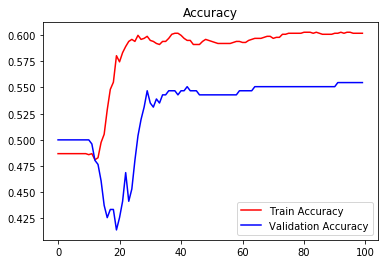

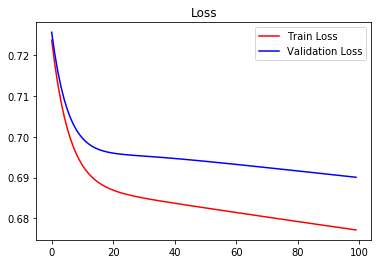

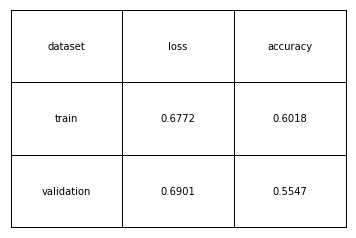

In [14]:
LR = 0.01
EPOCH = 100
change_activation(nn_architecture, ['sigmoid', 'sigmoid', 'sigmoid'])
params, loss_history, acc_history, vloss_history, vacc_history = train(train_data, train_label, validation_data, validation_label, nn_architecture, EPOCH, LR)
print_history_graph(loss_history, acc_history, vloss_history, vacc_history)

##### train and plot result
##### $ g^{[1]} = tanh, g^{[2]} = tanh, g^{[3]} = sigmoid $

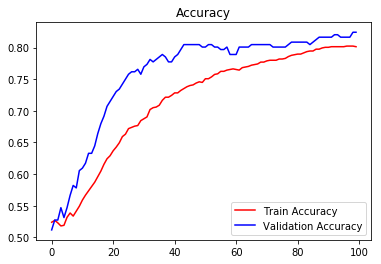

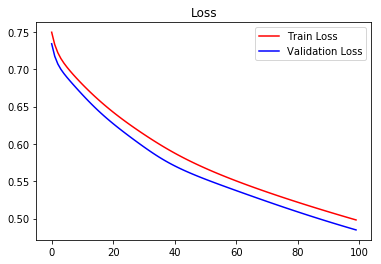

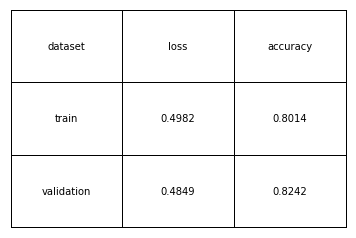

In [15]:
LR = LR
change_activation(nn_architecture, ['tanh', 'tanh', 'sigmoid'])
params, loss_history, acc_history, vloss_history, vacc_history = train(train_data, train_label, validation_data, validation_label, nn_architecture, EPOCH, LR)
print_history_graph(loss_history, acc_history, vloss_history, vacc_history)

##### train and plot result
##### $ g^{[1]} = relu, g^{[2]} = relu, g^{[3]} = sigmoid $

C:\Users\kjm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\kjm\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\kjm\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\kjm\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
C:\Users\kjm\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in maximum
  import sys
C:\Users\kjm\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal


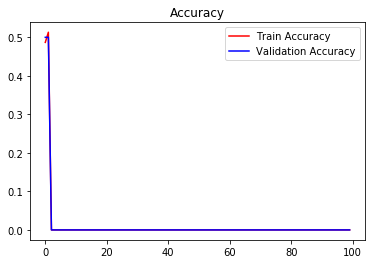

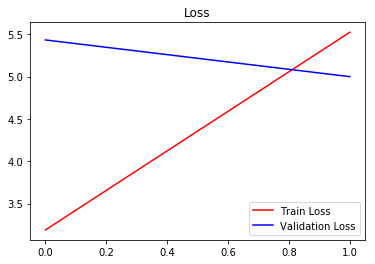

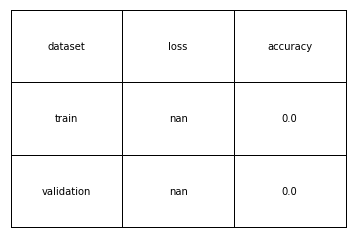

In [16]:
LR = 0.05
change_activation(nn_architecture, ['relu', 'relu', 'sigmoid'])
params, loss_history, acc_history, vloss_history, vacc_history = train(train_data, train_label, validation_data, validation_label, nn_architecture, EPOCH, LR)
print_history_graph(loss_history, acc_history, vloss_history, vacc_history)

##### train and plot result
##### $ g^{[1]} = leaky relu, g^{[2]} = leaky relu, g^{[3]} = sigmoid $

In [17]:
change_activation(nn_architecture, ['lrelu', 'lrelu', 'sigmoid'])
params, loss_history, acc_history, vloss_history, vacc_history = train(train_data, train_label, validation_data, validation_label, nn_architecture, EPOCH, LR)
print_history_graph(loss_history, acc_history, vloss_history, vacc_history)

TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions